# Лабораторная работа №8
## ПРОГНОЗИРОВАНИЕ ВРЕМЕННЫХ РЯДОВ
### Котов Иван Юрьевич
### Вариант: 14
### Группа: РИМ-181226

In [583]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy.stats as stats
from statsmodels.tsa import api as tsa
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

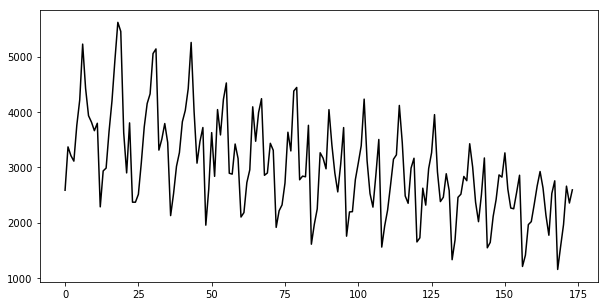

In [584]:
file = h5py.File('Fort.mat', 'r')
data = file.get('Fort')
Fort = np.array(data)
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k')
plt.show()

На глаз, в ряде видна явная
сезонность, присутствует некоторый убывающий тренд

Мы будем производить ретроспективный прогноз, то есть у нас
всегда будут точки, по которым можно будет сравнить, правильным
получился прогноз, или нет. Для этого отрежем от данного ряда
последние 24 точки (которые мы и будем прогнозировать):

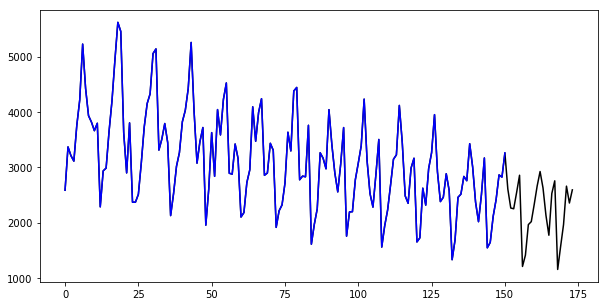

In [585]:
Z = Fort[:len(Fort)-24+1] # отрезаем последние 24 точки
t=np.arange(0, len(Z), 1) # временная шкала для регрессии
t=t.reshape(-1,1)
plt.figure(figsize = (10, 5))
plt.plot(Fort, 'k') # исходный ВР
plt.plot(t, Z, 'b') # урезанный ряд
plt.show()

## Прогнозы трендов

Начнем с простейших методов прогноза. Построим регрессионную
модель тренда первого, второго и третьего порядка на основе
методики, которая изучалась в лабораторной работе №3, а затем
используем полученные регрессионные кривые для прогноза тренда.

Дополняем время:

In [586]:
t=np.arange(0, len(Z), 1) # диапазон урезанного ряда
t=t.reshape(-1,1)
t0=np.arange(0, len(Fort), 1) # диапазон полного ряда
t0=t0.reshape(-1,1)
t_1 = t.reshape(-1)     # диапазон урезанного ряда
t0_1 = t0.reshape(-1)   # диапазон полного ряда
t_2 = np.vstack((np.vstack((np.ones(len(t_1)), t_1)),np.square(t_1))).T
t0_2 = np.vstack((np.vstack((np.ones(len(t0_1)), t0_1)),np.square(t0_1))).T
t_3 = np.vstack((np.vstack((np.vstack((np.ones(len(t_1)), t_1)),np.square(t_1))),np.power(t_1, 3))).T
t0_3 = np.vstack((np.vstack((np.vstack((np.ones(len(t0_1)), t0_1)),np.square(t0_1))),np.power(t0_1, 3))).T

Метрики:

In [587]:
def mean_prediction_error(y_true, y_pred): 
    return np.mean(np.abs(y_true - y_pred))

def mean_square_error(y_true, y_pred): 
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

def mean_approximation_error(y_true, y_pred): 
    return np.mean(np.abs(y_true - y_pred)/y_true)*100

def mismatch_rate_1(y_true, y_pred):
    return np.sqrt(np.sum(np.square(y_pred - y_true))/np.sum(np.square(y_true)))

def mismatch_rate_2(y_true, y_pred):
    return np.sqrt(np.sum(np.square(y_pred - y_true))/np.sum(np.square((np.average(y_pred) - y_true))))

def get_metrics(y_true,y_pred):
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    return mean_prediction_error(y_true,y_pred),\
           mean_square_error(y_true,y_pred),\
           mean_approximation_error(y_true,y_pred),\
           mismatch_rate_1(y_true,y_pred),\
           mismatch_rate_2(y_true,y_pred)
        
def print_metrics(y_true,y_pred):
    print('''Средняя ошибка прогноза:%f
             \nСКВО прогноза:%f
             \nСредняя ошибка аппроксимации:%f
             \nКоэффициент несоответствия 1:%f
             \nКоэффициент несоответствия 2:%f'''\
          %get_metrics(y_true,y_pred))      

## Регрессия

### 1 порядок

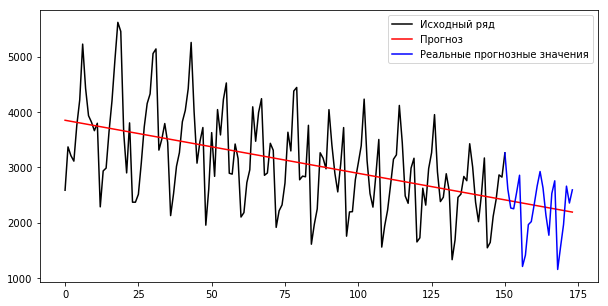

Средняя ошибка прогноза:574.052236
             
СКВО прогноза:724.305340
             
Средняя ошибка аппроксимации:21.464576
             
Коэффициент несоответствия 1:0.231009
             
Коэффициент несоответствия 2:0.825640


In [588]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(t, Z) # модель регрессии

plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k',label='Исходный ряд')
plt.plot(t0, reg.predict(t0), 'r',label='Прогноз') # прогноз на весь диапазон
plt.plot(t0[-24:], Fort[-24:], 'b',label='Реальные прогнозные значения') # реальные прогнозные значения
plt.legend()
plt.show()

print_metrics(Fort,reg.predict(t0))

### 2 порядок

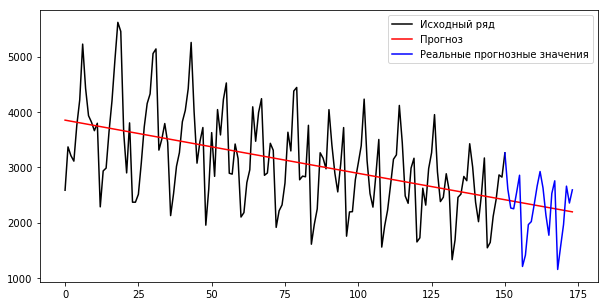

Средняя ошибка прогноза:574.035913
             
СКВО прогноза:724.342305
             
Средняя ошибка аппроксимации:21.467768
             
Коэффициент несоответствия 1:0.231021
             
Коэффициент несоответствия 2:0.825678


In [589]:
reg = LinearRegression().fit(t_2, Z.reshape(-1)) # модель регрессии

plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k',label='Исходный ряд')
plt.plot(t0, reg.predict(t0_2), 'r',label='Прогноз') # строим его тренд
plt.plot(t0[-24:], Fort[-24:], 'b',label='Реальные прогнозные значения') # реальные прогнозные значения
plt.legend()
plt.show()

print_metrics(Fort,reg.predict(t0_2))

### 3 порядок

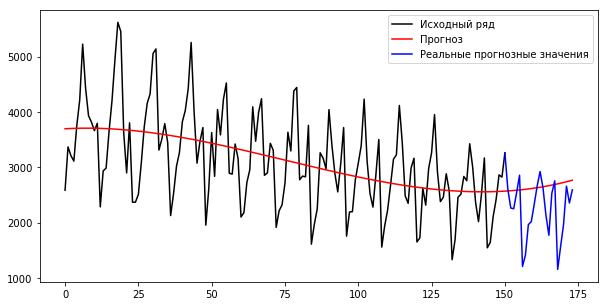

Средняя ошибка прогноза:580.661812
             
СКВО прогноза:738.121429
             
Средняя ошибка аппроксимации:22.221769
             
Коэффициент несоответствия 1:0.235416
             
Коэффициент несоответствия 2:0.839708


In [590]:
reg = LinearRegression().fit(t_3, Z.reshape(-1)) # модель регрессии

plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k',label='Исходный ряд')
plt.plot(t0, reg.predict(t0_3), 'r',label='Прогноз') # строим его тренд
plt.plot(t0[-24:], Fort[-24:], 'b',label='Реальные прогнозные значения') # реальные прогнозные значения
plt.legend()
plt.show()

print_metrics(Fort,reg.predict(t0_3))

## МНК

### 1 порядок

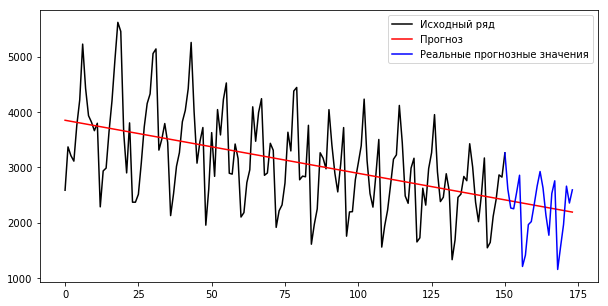

Средняя ошибка прогноза:574.052236
             
СКВО прогноза:724.305340
             
Средняя ошибка аппроксимации:21.464576
             
Коэффициент несоответствия 1:0.231009
             
Коэффициент несоответствия 2:0.825640


In [591]:
import statsmodels.api as sm
x_ = sm.add_constant(t)
smm = sm.OLS(Z, x_)
res = smm.fit() # строим модель регрессии

plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k',label='Исходный ряд')
plt.plot(t0, res.predict(sm.add_constant(t0)), 'r',label='Прогноз') # строим прогноз
plt.plot(t0[-24:], Fort[-24:], 'b',label='Реальные прогнозные значения') # реальные прогнозные значения
plt.legend()
plt.show()

print_metrics(Fort,res.predict(sm.add_constant(t0)))

### 2 порядок

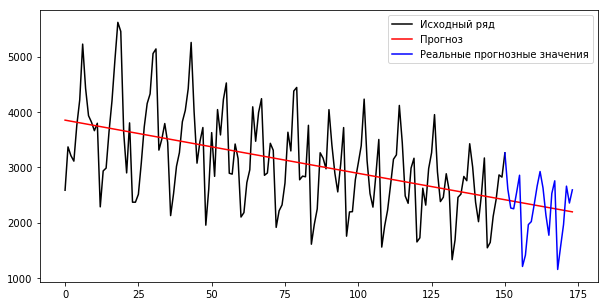

Средняя ошибка прогноза:574.035913
             
СКВО прогноза:724.342305
             
Средняя ошибка аппроксимации:21.467768
             
Коэффициент несоответствия 1:0.231021
             
Коэффициент несоответствия 2:0.825678


In [592]:
x_ = sm.add_constant(t_2)
smm = sm.OLS(Z, x_)
res = smm.fit() # строим модель регрессии

plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k',label='Исходный ряд')
plt.plot(t0, res.predict(sm.add_constant(t0_2)), 'r',label='Прогноз') # строим прогноз
plt.plot(t0[-24:], Fort[-24:], 'b',label='Реальные прогнозные значения') # реальные прогнозные значения
plt.legend()
plt.show()

print_metrics(Fort,res.predict(sm.add_constant(t0_2)))

### 3 порядок

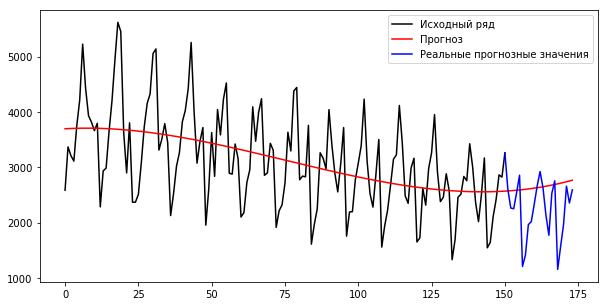

Средняя ошибка прогноза:580.661812
             
СКВО прогноза:738.121429
             
Средняя ошибка аппроксимации:22.221769
             
Коэффициент несоответствия 1:0.235416
             
Коэффициент несоответствия 2:0.839708


In [593]:
x_ = sm.add_constant(t_3)
smm = sm.OLS(Z, x_)
res = smm.fit() # строим модель регрессии

plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k',label='Исходный ряд')
plt.plot(t0, res.predict(sm.add_constant(t0_3)), 'r',label='Прогноз') # строим прогноз
plt.plot(t0[-24:], Fort[-24:], 'b',label='Реальные прогнозные значения') # реальные прогнозные значения
plt.legend()
plt.show()

print_metrics(Fort,res.predict(sm.add_constant(t0_3)))

## Polyfit

### 1 порядок

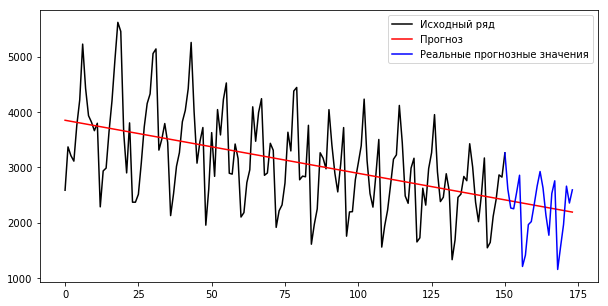

Средняя ошибка прогноза:574.052236
             
СКВО прогноза:724.305340
             
Средняя ошибка аппроксимации:21.464576
             
Коэффициент несоответствия 1:0.231009
             
Коэффициент несоответствия 2:0.825640


In [594]:
bb = np.polyfit(t.reshape(1,-1)[0], Z.reshape(1,-1)[0], 1)
p = np.poly1d(bb) # создаем экземпляр полинома

plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k',label='Исходный ряд')
plt.plot(t0, p(t0), 'r',label='Прогноз') # полином на прогнозной временной сетке
plt.plot(t0[-24:], Fort[-24:], 'b',label='Реальные прогнозные значения')
plt.legend()
plt.show()

print_metrics(Fort,p(t0))

### 2 порядок

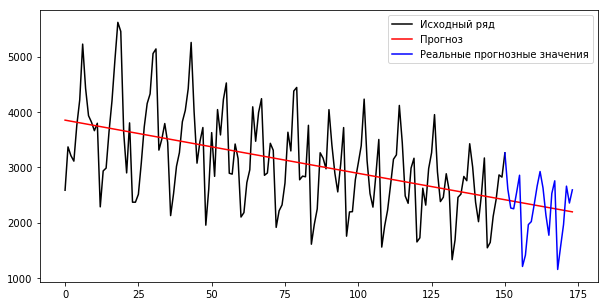

Средняя ошибка прогноза:574.035913
             
СКВО прогноза:724.342305
             
Средняя ошибка аппроксимации:21.467768
             
Коэффициент несоответствия 1:0.231021
             
Коэффициент несоответствия 2:0.825678


In [595]:
bb = np.polyfit(t_1, Z.reshape(1,-1)[0], 2)
p = np.poly1d(bb) # создаем экземпляр полинома

plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k',label='Исходный ряд')
plt.plot(t0, p(t0), 'r',label='Прогноз') # полином на прогнозной временной сетке
plt.plot(t0[-24:], Fort[-24:], 'b',label='Реальные прогнозные значения')
plt.legend()
plt.show()

print_metrics(Fort,p(t0))

### 3 порядок

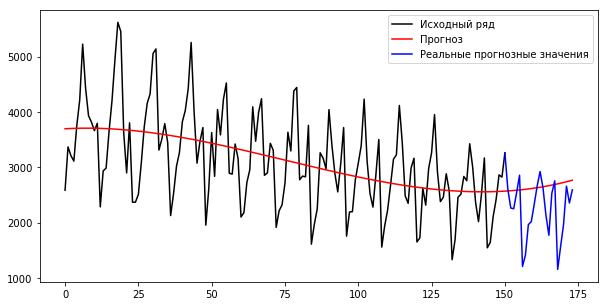

Средняя ошибка прогноза:580.661812
             
СКВО прогноза:738.121429
             
Средняя ошибка аппроксимации:22.221769
             
Коэффициент несоответствия 1:0.235416
             
Коэффициент несоответствия 2:0.839708


In [596]:
bb = np.polyfit(t_1, Z.reshape(1,-1)[0], 3)
p = np.poly1d(bb) # создаем экземпляр полинома

plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k',label='Исходный ряд')
plt.plot(t0, p(t0), 'r',label='Прогноз') # полином на прогнозной временной сетке
plt.plot(t0[-24:], Fort[-24:], 'b',label='Реальные прогнозные значения')
plt.legend()
plt.show()

print_metrics(Fort,p(t0))

## scipy.optimize

### 1 порядок

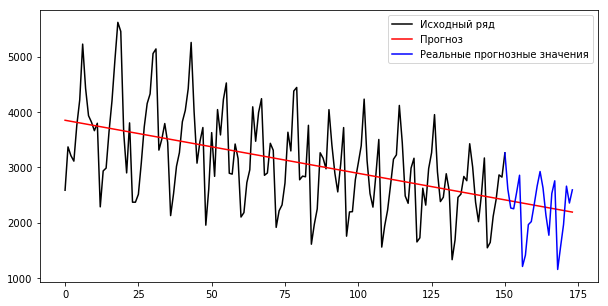

Средняя ошибка прогноза:574.052236
             
СКВО прогноза:724.305340
             
Средняя ошибка аппроксимации:21.464576
             
Коэффициент несоответствия 1:0.231009
             
Коэффициент несоответствия 2:0.825640


In [597]:
def func(t, b0, b1):
    return b0 + b1 * t

from scipy.optimize import curve_fit
popt, pcov = curve_fit(func, t.reshape(1,-1)[0], Z.reshape(1,-1)[0])

plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k',label='Исходный ряд')
plt.plot(t0, t0*popt[1]+popt[0], 'r',label='Прогноз')
plt.plot(t0[-24:], Fort[-24:], 'b',label='Реальные прогнозные значения')
plt.legend()
plt.show()

print_metrics(Fort,t0*popt[1]+popt[0])

### 2 порядок

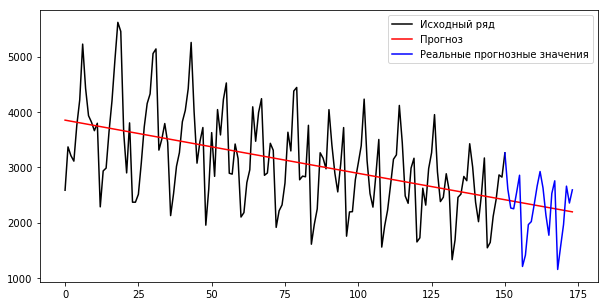

Средняя ошибка прогноза:574.035913
             
СКВО прогноза:724.342305
             
Средняя ошибка аппроксимации:21.467768
             
Коэффициент несоответствия 1:0.231021
             
Коэффициент несоответствия 2:0.825678


In [598]:
def func2(t, b0, b1, b2): # описываем функцию тренда
    return b0 + b1 * t + b2 * np.square(t) 

popt, pcov = curve_fit(func2, t_1, Z.reshape(1,-1)[0]) # проводим подгонку МНК

plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k',label='Исходный ряд')
plt.plot(t0, np.square(t0)*popt[2]+t0*popt[1]+popt[0], 'r',label='Прогноз')
plt.plot(t0[-24:], Fort[-24:], 'b',label='Реальные прогнозные значения')
plt.legend()
plt.show()

print_metrics(Fort,np.square(t0)*popt[2]+t0*popt[1]+popt[0])

### 3 порядок

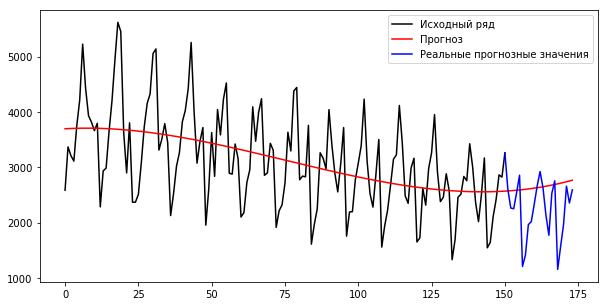

Средняя ошибка прогноза:580.661812
             
СКВО прогноза:738.121428
             
Средняя ошибка аппроксимации:22.221769
             
Коэффициент несоответствия 1:0.235416
             
Коэффициент несоответствия 2:0.839708


In [599]:
def func3(t, b0, b1, b2, b3): # описываем функцию тренда
    return b0 + b1 * t + b2 * np.square(t) + b3 * np.power(t,3) 

popt, pcov = curve_fit(func3, t_1, Z.reshape(1,-1)[0]) # проводим подгонку МНК

plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k',label='Исходный ряд')
plt.plot(t0, np.power(t0,3)*popt[3]+np.square(t0)*popt[2]+t0*popt[1]+popt[0], 'r',label='Прогноз')
plt.plot(t0[-24:], Fort[-24:], 'b',label='Реальные прогнозные значения')
plt.legend()
plt.show()

print_metrics(Fort,np.power(t0,3)*popt[3]+np.square(t0)*popt[2]+t0*popt[1]+popt[0])

## Доверительные интервалы

Постройте доверительные интервалы для тренда первого порядка
на рисунке вместе с прогнозом и самим рядом по следующей
методике

In [600]:
def get_interval_1(y_true, y_pred):
    
    N = len(y_true)
    S = np.sqrt(np.sum(np.square(y_true - y_pred))/(N - 2))
    
    return 1.96*\
           S*\
           np.sqrt(1+(1/N)+\
          (np.square(y_true - np.average(y_pred))/\
           np.sum(np.square(y_pred - np.average(y_pred)))))
    
def get_interval_23(y_true, y_pred):
    
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    
    return 1.96*\
           np.sqrt(np.mean(np.square(y_true - y_pred)))           

### 1 порядок

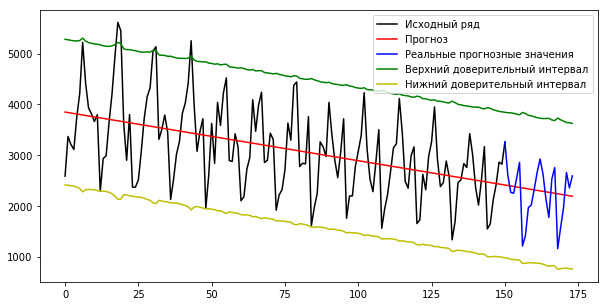

In [601]:
reg = LinearRegression().fit(t, Z) # модель регрессии

plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k',label='Исходный ряд')
plt.plot(t0, reg.predict(t0), 'r',label='Прогноз') # прогноз на весь диапазон
plt.plot(t0[-24:], Fort[-24:], 'b',label='Реальные прогнозные значения') # реальные прогнозные значения

interval = get_interval_1(Fort,reg.predict(t0))
plt.plot(t0, reg.predict(t0) + interval, 'g',label='Верхний доверительный интервал') 
plt.plot(t0, reg.predict(t0) - interval, 'y',label='Нижний доверительный интервал') 

plt.legend()
plt.show()

### 2 порядок

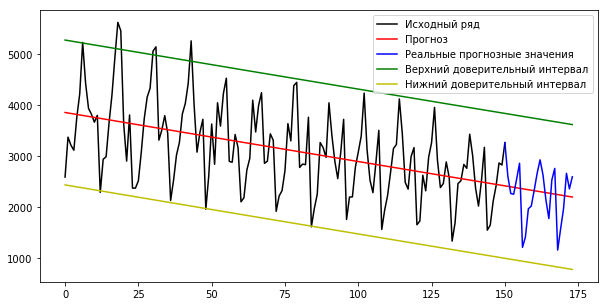

In [602]:
reg = LinearRegression().fit(t_2, Z.reshape(-1)) # модель регрессии
plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k',label='Исходный ряд')
plt.plot(t0, reg.predict(t0_2), 'r',label='Прогноз') # строим его тренд
plt.plot(t0[-24:], Fort[-24:], 'b',label='Реальные прогнозные значения') # реальные прогнозные значения

interval = get_interval_23(Fort,reg.predict(t0_2))
plt.plot(t0, reg.predict(t0_2) + interval, 'g',label='Верхний доверительный интервал') 
plt.plot(t0, reg.predict(t0_2) - interval, 'y',label='Нижний доверительный интервал') 

plt.legend()
plt.show()

### 3 порядок

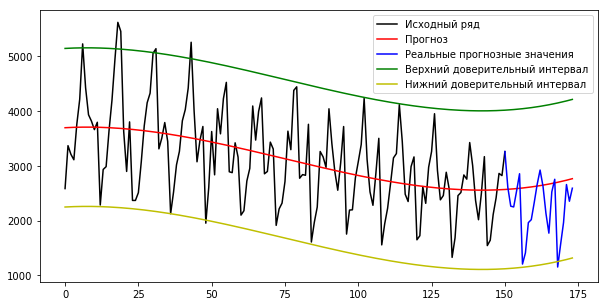

In [603]:
reg = LinearRegression().fit(t_3, Z.reshape(-1)) # модель регрессии

plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k',label='Исходный ряд')
plt.plot(t0, reg.predict(t0_3), 'r',label='Прогноз') # строим его тренд
plt.plot(t0[-24:], Fort[-24:], 'b',label='Реальные прогнозные значения') # реальные прогнозные значения

interval = get_interval_23(Fort,reg.predict(t0_3))
plt.plot(t0, reg.predict(t0_3) + interval, 'g',label='Верхний доверительный интервал')
plt.plot(t0, reg.predict(t0_3) - interval, 'y',label='Нижний доверительный интервал') 

plt.legend()
plt.show()

Метод построения регрессионной кривой через подгонку
функций библиотеки scipy.optimize позволяет по МНК задавать
любую форму кривой. Попробуйте самостоятельно задать некоторую
параметрическую кривую, которая давала бы более высокую
точность, нежели простые линейные регрессионные кривые. Оцените
ее точность аналогично и постройте эмпирические оценки
доверительных интервалов

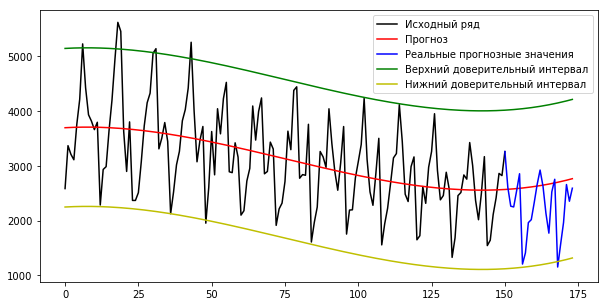

Средняя ошибка прогноза:580.661812
             
СКВО прогноза:738.121428
             
Средняя ошибка аппроксимации:22.221769
             
Коэффициент несоответствия 1:0.235416
             
Коэффициент несоответствия 2:0.839708


In [604]:
def func3(t, b0, b1, b2, b3): # описываем функцию тренда
    return b0 + b1 * t + b2 * np.square(t) + b3 * np.power(t,3) 

popt, pcov = curve_fit(func3, t_1, Z.reshape(1,-1)[0]) # проводим подгонку МНК
trend = np.power(t0,3)*popt[3]+np.square(t0)*popt[2]+t0*popt[1]+popt[0]

plt.figure(figsize = (10, 5))
plt.plot(t, Z, 'k',label='Исходный ряд')
plt.plot(t0, trend, 'r',label='Прогноз')
plt.plot(t0[-24:], Fort[-24:], 'b',label='Реальные прогнозные значения')

interval = get_interval_23(Fort,trend)
plt.plot(t0, trend + interval, 'g',label='Верхний доверительный интервал')
plt.plot(t0, trend - interval, 'y',label='Нижний доверительный интервал') 

plt.legend()
plt.show()

print_metrics(Fort,trend)

Теперь обратимся к прогнозированию на основе АРПСС моделей.
Но прежде, чем строить такую модель, обратите внимание: модели
АРПСС строятся для рядов с около-нулевым средним, что неверно
для заданного временного ряда. Поэтому – сначала постройте
линейный тренд прогнозируемого ряда (см. линейную регрессию
первого порядка выше), а затем вычтите его из исходного ряда,
приведя его к нулевому среднему значению (к так называемой трендстационарной форме). 

### АРПСС для ряда в тренд-стационарной форме

In [605]:
reg = LinearRegression().fit(t0, Fort) 
Fort_ts = Fort - reg.predict(t0) #  тренд-стационарная форма исходного ряда

reg = LinearRegression().fit(t, Z) 
Z_ts = Z - reg.predict(t) #  тренд-стационарная форма укороченного ряда

In [606]:
from itertools import combinations
x = [0,1,2,3,0,1,2,3,0,1,2,3]
all_params = sorted(set(list(combinations(x, 3))))

for p1,p2,p3 in all_params:
    try:
        arima = ARIMA(Z_ts, order = (p1, p2, p3)) # создаем модель
        model_fit = arima.fit(disp = False,trend='nc') # подгоняем под ВР
        print('order(',p1,',',p2,',',p3,'): BIC = ',' ',model_fit.bic) # выводим таблицу результатов
    except:
        continue      

order( 0 , 0 , 1 ): BIC =    2395.11286193
order( 0 , 0 , 2 ): BIC =    2398.79304017
order( 0 , 0 , 3 ): BIC =    2402.25294407
order( 0 , 1 , 1 ): BIC =    2420.75391633
order( 0 , 1 , 2 ): BIC =    2389.46461838
order( 0 , 1 , 3 ): BIC =    2392.96465791
order( 0 , 2 , 1 ): BIC =    2415.02099173
order( 1 , 0 , 0 ): BIC =    2397.82172397
order( 1 , 0 , 1 ): BIC =    2398.47309229
order( 1 , 0 , 2 ): BIC =    2392.26462535
order( 1 , 0 , 3 ): BIC =    2392.87944497
order( 1 , 1 , 0 ): BIC =    2422.85842157
order( 1 , 1 , 1 ): BIC =    2391.66750132
order( 1 , 1 , 2 ): BIC =    2392.55730222
order( 1 , 1 , 3 ): BIC =    2397.56344224
order( 1 , 2 , 0 ): BIC =    2496.16583275
order( 2 , 0 , 0 ): BIC =    2398.32732403
order( 2 , 0 , 1 ): BIC =    2375.01577523
order( 2 , 0 , 2 ): BIC =    2338.78315357
order( 2 , 0 , 3 ): BIC =    2346.58696855
order( 2 , 1 , 0 ): BIC =    2418.57170497
order( 2 , 1 , 1 ): BIC =    2392.51172568
order( 2 , 1 , 2 ): BIC =    2395.02827341
order( 2 , 

In [607]:
arimaz = ARIMA(Z_ts, order = (2, 0, 2))
model_fit = arimaz.fit(disp = False,trend='nc') # подгоняем под ВР
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  151
Model:                     ARMA(2, 2)   Log Likelihood               -1156.848
Method:                       css-mle   S.D. of innovations            505.572
Date:                Sun, 19 May 2019   AIC                           2323.697
Time:                        23:29:53   BIC                           2338.783
Sample:                             0   HQIC                          2329.826
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        1.7305      0.005    336.980      0.000       1.720       1.741
ar.L2.y       -0.9964      0.004   -226.638      0.000      -1.005      -0.988
ma.L1.y       -1.7184      0.034    -49.890      0.0

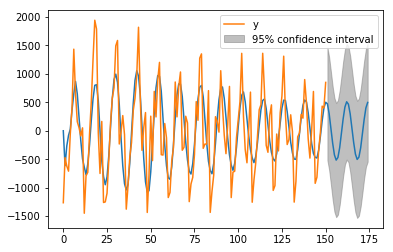

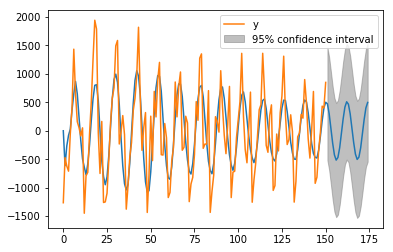

In [608]:
model_fit.plot_predict(0, len(Fort))

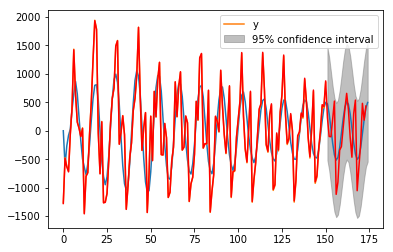

In [609]:
plt.figure(figsize = (10, 5))
model_fit.plot_predict(0, len(Fort)) # прогноз по АРПСС
plt.plot(t0, Fort_ts, 'r') # исходный ВР минус тренд
plt.show()

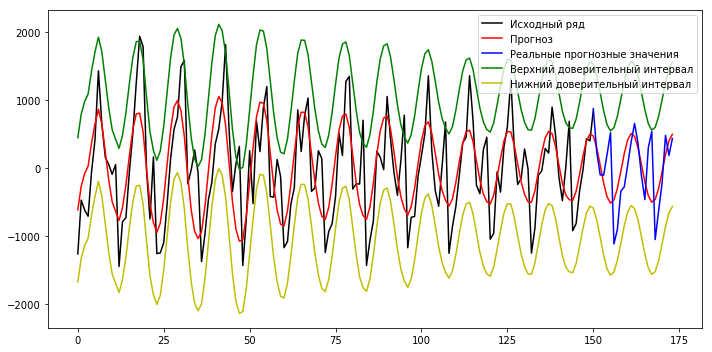

Средняя ошибка прогноза:441.323042
             
СКВО прогноза:541.972146
             
Средняя ошибка аппроксимации:107.628937
             
Коэффициент несоответствия 1:0.748459
             
Коэффициент несоответствия 2:0.748459


In [610]:
arima_predict = model_fit.predict(1, len(Fort))

plt.figure(figsize = (10, 5))
plt.plot(t, Z_ts, 'k',label='Исходный ряд')
plt.plot(t0, arima_predict, 'r',label='Прогноз') 
plt.plot(t0[-24:], Fort_ts[-24:], 'b',label='Реальные прогнозные значения')

interval = get_interval_23(Fort_ts,arima_predict)
plt.plot(t0, arima_predict + interval, 'g',label='Верхний доверительный интервал')
plt.plot(t0, arima_predict - interval, 'y',label='Нижний доверительный интервал') 

plt.tight_layout()
plt.legend()
plt.show()

print_metrics(Fort_ts,arima_predict)

### АРПСС для ряда в исходной форме

In [611]:
from itertools import combinations
x = [0,1,2,3,0,1,2,3,0,1,2,3]
all_params = sorted(set(list(combinations(x, 3))))

for p1,p2,p3 in all_params:
    try:
        arima = ARIMA(Z, order = (p1, p2, p3)) # создаем модель
        model_fit = arima.fit(disp = False,trend='nc') # подгоняем под ВР
        print('order(',p1,',',p2,',',p3,'): BIC = ',' ',model_fit.bic) # выводим таблицу результатов
    except:
        continue      

order( 0 , 0 , 1 ): BIC =    2709.96630196
order( 0 , 0 , 2 ): BIC =    2625.48474002
order( 0 , 0 , 3 ): BIC =    2564.7632465
order( 0 , 1 , 1 ): BIC =    2420.68917523
order( 0 , 1 , 2 ): BIC =    2396.46831084
order( 0 , 1 , 3 ): BIC =    2399.46548297
order( 0 , 2 , 1 ): BIC =    2415.02099173
order( 1 , 0 , 0 ): BIC =    2441.91339802
order( 1 , 0 , 1 ): BIC =    2443.34600249
order( 1 , 0 , 2 ): BIC =    2420.44549135
order( 1 , 0 , 3 ): BIC =    2423.44815662
order( 1 , 1 , 0 ): BIC =    2422.80459538
order( 1 , 1 , 1 ): BIC =    2397.08187326
order( 1 , 1 , 2 ): BIC =    2398.71918742
order( 1 , 1 , 3 ): BIC =    2403.68932096
order( 1 , 2 , 0 ): BIC =    2496.16583275
order( 2 , 0 , 0 ): BIC =    2445.0454618
order( 2 , 0 , 1 ): BIC =    2452.62936224
order( 2 , 0 , 2 ): BIC =    2453.9001423
order( 2 , 0 , 3 ): BIC =    2442.83983904
order( 2 , 1 , 0 ): BIC =    2418.49575625
order( 2 , 1 , 1 ): BIC =    2398.94489712
order( 2 , 1 , 2 ): BIC =    2400.85022014
order( 2 , 1 ,

In [612]:
arimaz = ARIMA(Z, order = (1,0,2))
model_fit = arimaz.fit(disp = False,trend='nc') # подгоняем под ВР
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  151
Model:                     ARMA(1, 2)   Log Likelihood               -1200.188
Method:                       css-mle   S.D. of innovations            673.945
Date:                Sun, 19 May 2019   AIC                           2408.376
Time:                        23:29:59   BIC                           2420.445
Sample:                             0   HQIC                          2413.279
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.9998      0.000   4022.890      0.000       0.999       1.000
ma.L1.y       -0.3921      0.073     -5.355      0.000      -0.536      -0.249
ma.L2.y       -0.5256      0.071     -7.353      0.0

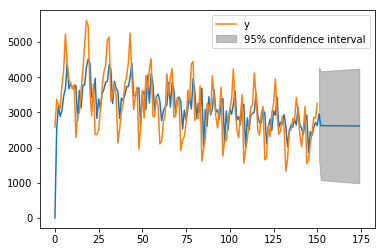

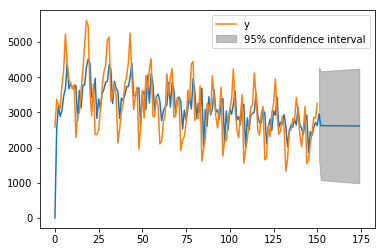

In [613]:
model_fit.plot_predict(0, len(Fort))

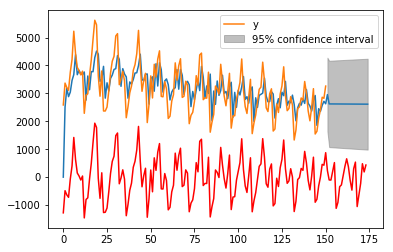

In [614]:
plt.figure(figsize = (10, 5))
model_fit.plot_predict(0, len(Fort)) # прогноз по АРПСС
plt.plot(t0, Fort_ts, 'r') # исходный ВР минус тренд
plt.show()

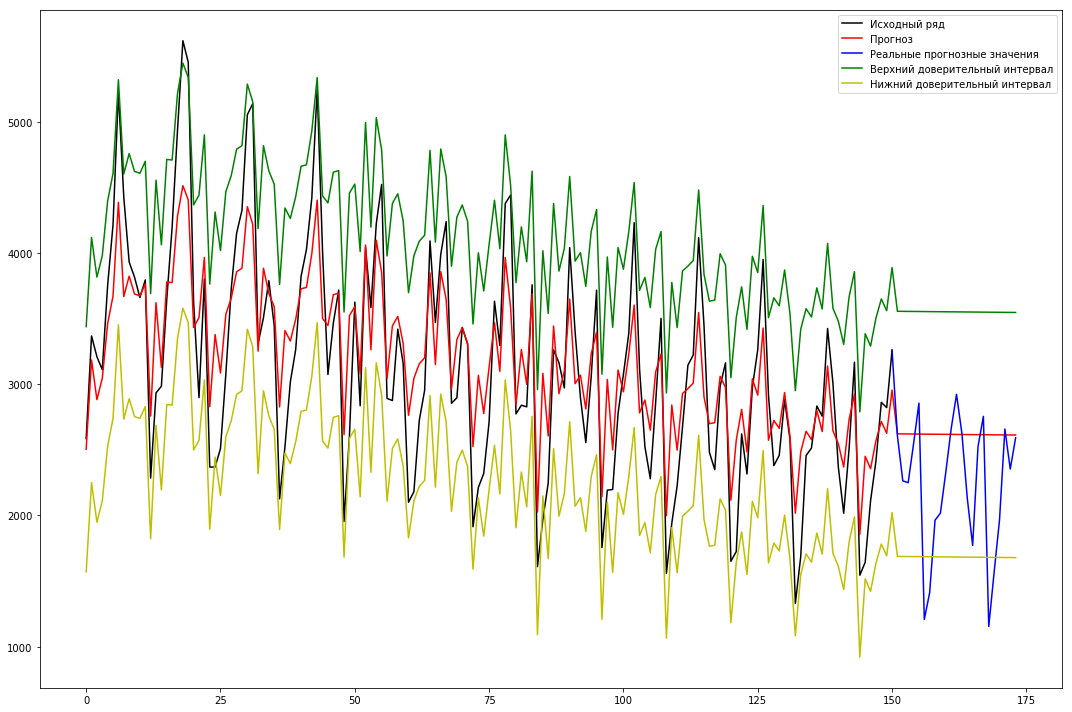

Средняя ошибка прогноза:372.570649
             
СКВО прогноза:476.559755
             
Средняя ошибка аппроксимации:14.969888
             
Коэффициент несоответствия 1:0.151993
             
Коэффициент несоответствия 2:0.539945


In [615]:
arima_predict = model_fit.predict(1, len(Fort))

plt.figure(figsize = (15, 10))
plt.plot(t, Z, 'k',label='Исходный ряд')
plt.plot(t0, arima_predict, 'r',label='Прогноз') 
plt.plot(t0[-24:], Fort[-24:], 'b',label='Реальные прогнозные значения')

interval = get_interval_23(Fort,arima_predict)
plt.plot(t0, arima_predict + interval, 'g',label='Верхний доверительный интервал')
plt.plot(t0, arima_predict - interval, 'y',label='Нижний доверительный интервал')

plt.tight_layout()
plt.legend()
plt.show()

print_metrics(Fort,arima_predict)